# CS3710 Project Report

In [1]:
%load_ext autoreload
%autoreload 2

# data analysis
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

import os
#os.chdir('src'); 
print(f"Current Directory: {os.getcwd()}")

# source code
from src.lib import *
from src.gaes import *
from src.pop import *

import json
import requests
from tqdm.notebook import tqdm
import torch # NN
import statsmodels.api as sm
import matplotlib.patches as patches

Current Directory: /home/kibit/pitt/CS3710/cs3710-proj


# GAES

In [2]:
G = GAES(census_shapes_json="data/2016_census_block.geojson",census_transport_data_csv="data/transport_census.csv")

[init] pulled 402 tract shapes
[init] pulled data for 1304 tracts
[init] pulled data for 1057 city zones
[init] pulled equity scores for 428 tracts
[init] pulled 6648 stops
[init] binned by stop, there are 108 bins
[init] pulled 87806 segments
[init] pulled 95 lines
[init] lines' stop arrays successfully re-ordered


outputting data to train on colab

# GMAPS

In [74]:
with open('./all_nearby.json') as f:
    nearby_search = json.load(f)

found = set()
for info in nearby_search.values():
    for place in info:
        types = place['types']
        found.update(set(types))

print(len(found)) 

to_index = dict(zip(found, range(len(found))))
map_data = np.zeros((len(nearby_search), len(found) + 1)) # initialize matrix (n_stops, n_types + 1), add one for the id

for i, stops in enumerate(nearby_search.items()):
    stop_id, stop_places = stops

    all = np.zeros(len(found)) # sparse
    for place in stop_places:
        types = [to_index[t] for t in place['types']]
        all[types] += 1
        
    map_data[i] = np.concatenate([[stop_id], all])

186


In [6]:
map_data.shape

(6648, 187)

In [7]:
stops = G.stops
segments = G.segs[['stopFrom', 'stopTo', 'avgLoad', 'tripCount']]
segments[:5]
print(segments.shape); print(len(set(stops.keys())))

(91816,)
6648


In [8]:
nfeats = (6*3) + map_data.shape[1] - 1; print(nfeats)
data = np.zeros(shape = (segments.shape[0], 2, nfeats))
loads = []
missing = 0

for s in range(segments.shape[0]):
    try:
        seg = segments[s]
        fromid = seg['stopFrom']
        toid = seg['stopTo']
        stopfrom = stops[fromid]
        stopto = stops[toid]

        fromtract = int(stopfrom.tract)
        totract = int(stopto.tract)

        fromdata = G.census_data[G.census_data['tract_id'] == fromtract]
        todata = G.census_data[G.census_data['tract_id'] == totract]

        # alone, carpooled, public
        flat_from = [t for t in fromdata[1:]]
        flat_to = [t for t in todata[1:]]

        # median age, median income, % owned houses, black, asian, white
        orderedfrom = np.array([[x[2],x[4],x[5]] + list(x[3]) for x in flat_from]).flatten()
        orderedto = np.array([[x[2],x[4],x[5]] + list(x[3]) for x in flat_to]).flatten()

        # bus stop businesses (1 km radius)
        fromdata = map_data[map_data[:,0] == fromid][0,1:]
        todata = map_data[map_data[:,0] == toid][0,1:]
        orderedfrom = np.concatenate([orderedfrom, fromdata])
        orderedto = np.concatenate([orderedto, todata])

        data[s] = np.array([orderedfrom, orderedto])
        loads.append(seg['avgLoad'])
    except:
        missing += 1
        #print(f"error on {fromid}")

print(f"{missing = }")

204
missing = 9996


In [9]:
mask = ~(data == 0).all(axis = (1,2))
qc_data = data[mask]
qc_data.shape[0] == len(loads)

True

In [10]:
#np.save('./demand_data.npy', qc_data, allow_pickle = False)
#np.save('./demand_true.npy', loads, allow_pickle = False)

### Brief Data Analysis

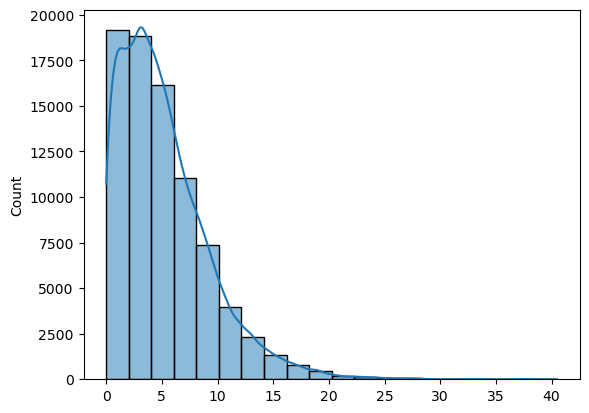

In [11]:
ax = sns.histplot(x = loads, bins = 20, kde = True) # dayumn she skewed; can be fixed w log transform but shouldnt matter

In [12]:
demand_in_tract = {}
oops = 0
for seg in G.segs:
    try:
        source_id = seg['stopFrom']
        sink_id = seg['stopTo']

        source = G.stops[source_id]
        sink = G.stops[sink_id]

        # add source information to its tract
        if source.tract in demand_in_tract:
            demand_in_tract[source.tract][0] += seg['avgLoad']
            demand_in_tract[source.tract][1] += seg['tripCount']
        else:
            demand_in_tract[source.tract] = [0,0]
            demand_in_tract[source.tract][0] += seg['avgLoad']
            demand_in_tract[source.tract][1] += seg['tripCount']
        if source.tract == sink.tract: continue # don't add info twice
        # add sink info
        else:
            if sink.tract in demand_in_tract:
                demand_in_tract[sink.tract][0] += seg['avgLoad']
                demand_in_tract[sink.tract][1] += seg['tripCount']
            else:
                demand_in_tract[sink.tract] = [0,0]
                demand_in_tract[sink.tract][0] += seg['avgLoad']
                demand_in_tract[sink.tract][1] += seg['tripCount']
    except:
        oops += 1

In [13]:
demand_df = pd.DataFrame(demand_in_tract).T.rename(columns={0: "avgLoad", 1: "tripCount"}); print(demand_df.shape)
demand_df.head(5)

(340, 2)


,avgLoad,tripCount
203,6322.994781,10152.0
605,4120.134078,4002.0
603,5061.346189,6959.0
902,1722.323036,2870.0
5138,1345.347337,4110.0


In [14]:
mi = []
black, asian, white = [], [], []
for t in demand_df.index:
        try:
            cd = G.census_data[G.census_data['tract_id'] == int(t)][0]
        except:
            mi.append(np.nan)
            black.append(np.nan)
            asian.append(np.nan)
            white.append(np.nan)
            continue
        mi.append(cd['median_income'])
        b, a, w = cd['demographics']
        black.append(b)
        asian.append(a)
        white.append(w)

In [15]:
meta_info = pd.DataFrame(
    {
        'mi' : mi,
        'black' : black,
        'asian' : asian,
        'white' : white
    }
)

In [16]:
print(demand_df.shape)
print(meta_info.shape)

(340, 2)
(340, 4)


In [17]:
demo_df = pd.concat(
    [demand_df.reset_index(names = 'tract_id'), meta_info], 
    ignore_index = False, axis = 1
).set_index('tract_id')
demo_df

,avgLoad,tripCount,mi,black,asian,white
tract_id,,,,,,
203,6322.994781,10152.0,78250.0,92.9,1.7,4.8
605,4120.134078,4002.0,38102.0,93.7,2.1,0.0
603,5061.346189,6959.0,43232.0,88.9,7.5,1.6
902,1722.323036,2870.0,43325.0,94.2,0.8,3.1
5138,1345.347337,4110.0,20793.0,21.6,71.8,0.0
...,...,...,...,...,...,...
4734.02,15.981444,72.0,NaN,NaN,NaN,NaN
4741.02,6.083219,108.0,NaN,NaN,NaN,NaN
4723,200.274521,162.0,36591.0,86.3,7.9,1.3


[Text(0.5, 1.0, 'Average Load vs. Number of Trips across Tracts')]

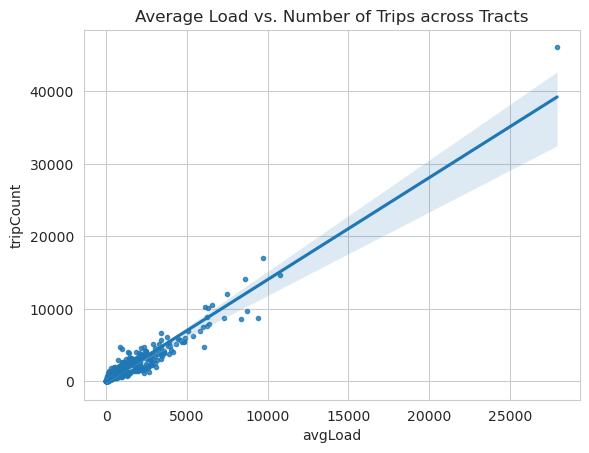

In [18]:
sns.set_style("whitegrid")
ax = sns.regplot(data = demo_df, x = 'avgLoad', y = 'tripCount', marker = '.') # highly correlated
ax.set(title = "Average Load vs. Number of Trips across Tracts")

5 most and 5 least average loads

In [19]:
top_demand = demo_df.sort_values(by = 'avgLoad', ascending = True).iloc[np.linspace(-50,-1,50)]
least_demand = demo_df.sort_values(by = 'avgLoad', ascending = True).iloc[np.linspace(0,49,50)]

In [20]:
temp = top_demand.dropna()
X = sm.add_constant(temp[['black','asian','white','mi']].to_numpy())
lm = sm.OLS(temp['avgLoad'].to_numpy(), X).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.090
Method:                 Least Squares   F-statistic:                   0.04939
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.995
Time:                        14:02:01   Log-Likelihood:                -454.02
No. Observations:                  47   AIC:                             918.0
Df Residuals:                      42   BIC:                             927.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7757.2549   2.78e+04      0.279      0.7

NameError: name 'top_demand' is not defined

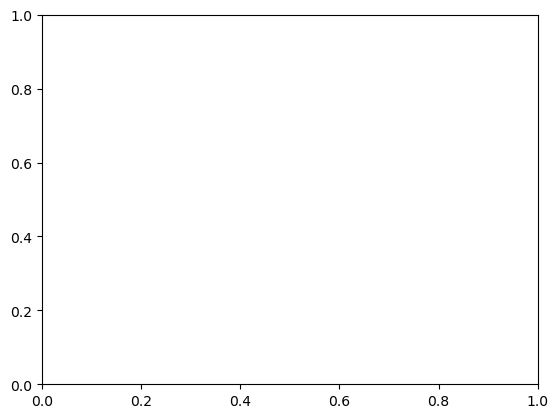

In [6]:
import matplotlib.patches as patches

fig, ax = plt.subplots()
for tract in top_demand.index:
    p = G.census_shapes[tract]
    patch = patches.PathPatch(p.geometry, facecolor='orange', lw=0.75)
    ax.add_patch(patch)

for tract in least_demand.index:
    p = G.census_shapes[tract]
    patch = patches.PathPatch(p.geometry, facecolor='blue', lw=0.75)
    ax.add_patch(patch)

#ax.set_xlim(-80.12, -79.85)
#ax.set_ylim(40.35, 40.51)
ax.set(title = "Highest and Lowest Demand Tracts")
plt.autoscale()
plt.show()

### MLP

In [7]:
nfeats = 2 * 204

In [3]:
class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_size, dropout):
        '''
        Multilayer perceptron w/ norm layers
        '''
        super(MultiLayerPerceptron, self).__init__()

        self.hidden = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.BatchNorm1d(hidden_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size, hidden_size//2),
            torch.nn.BatchNorm1d(hidden_size//2),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size//2, hidden_size//4),
            torch.nn.BatchNorm1d(hidden_size//4),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_size//4, 1),
        )

    def forward(self, X):
        if not torch.is_tensor(X):
            X = torch.tensor(X)
        X = X.reshape(X.shape[0], -1).to(torch.float32) # (batch, 2 * 18)
        out = self.hidden(X)
        return out

In [4]:
PATH = "mlp.pth" # path to saved .pt model file
MLP = MultiLayerPerceptron(
    input_size = 408,
    hidden_size = 1000,
    dropout = 0.4
)

MLP.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
MLP.eval()

MultiLayerPerceptron(
  (hidden): Sequential(
    (0): Dropout(p=0.4, inplace=False)
    (1): Linear(in_features=408, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=500, out_features=250, bias=True)
    (8): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=250, out_features=1, bias=True)
  )
)

making a prediction

In [75]:
total = 0
for k,v in network.items():
    for i in v:
        total+=1

In [76]:
stop_to_index = dict(zip(list(G.stops.keys()), range(len(G.stops.keys()))))

In [77]:
nfeats = (6*3) + map_data.shape[1] - 1; print(nfeats)

data = np.zeros(shape = (total, 2, nfeats)) # data for each combo of stops
missing = set()
stops = []
mi = []
demand_matrix = np.zeros(shape = (len(G.stops), len(G.stops))) # demand matrix

i = 0
for source,sinks in network.items():
    try:
        for s in sinks:
            stopfrom = source
            sourceid = stopfrom.cleverid
            stopto = s
            sinkid = stopto.cleverid

            fromtract = int(stopfrom.tract)
            totract = int(stopto.tract)

            fromdata = G.census_data[G.census_data['tract_id'] == fromtract]
            todata = G.census_data[G.census_data['tract_id'] == totract]

            # alone, carpooled, public
            flat_from = [t for t in fromdata[1:]]
            flat_to = [t for t in todata[1:]]

            # median age, median income, % owned houses, black, asian, white
            orderedfrom = np.array([[x[2],x[4],x[5]] + list(x[3]) for x in flat_from]).flatten()
            orderedto = np.array([[x[2],x[4],x[5]] + list(x[3]) for x in flat_to]).flatten()

            # bus stop businesses (1 km radius)
            fromdata = map_data[map_data[:,0] == sourceid][0,1:]
            todata = map_data[map_data[:,0] == sinkid][0,1:]
            orderedfrom = np.concatenate([orderedfrom, fromdata])
            orderedfrom[orderedfrom == None] = 0
            orderedto = np.concatenate([orderedto, todata])
            orderedto[orderedto == None] = 0

            data[i] = np.array([orderedfrom, orderedto])
            stops.append((sourceid,sinkid))
            i+=1
    except:
        missing.add((sourceid,sinkid))
        mi.append(i)
        i+=1

print(f"{len(missing) = }")
data = np.delete(data, mi, 0)

204
len(missing) = 1666


In [11]:
#np.save('./data/temp_demand_data.npy', data, allow_pickle = False)

In [149]:
demands = np.load('./data/all_demands.npy')

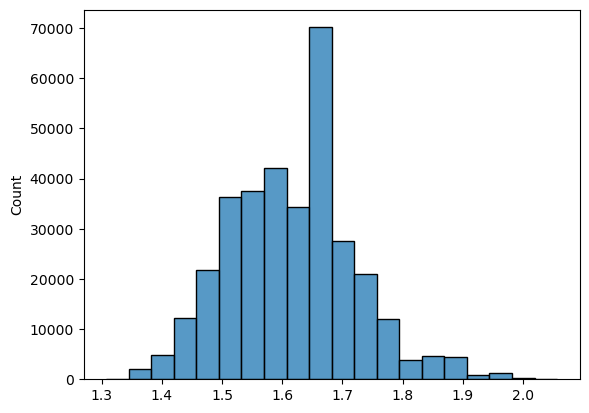

In [153]:
ax = sns.histplot(x = demands, bins = 20)

In [154]:
np.mean(demands)

1.6178801

In [79]:
for i,s in enumerate(stops):
    source = stop_to_index[s[0]]
    sink = stop_to_index[s[1]]
    demand_matrix[source,sink] = demands[i]

In [85]:
np.all(np.diag(demand_matrix) == np.zeros(demand_matrix.shape[0]))

True

In [81]:
for stops in missing:
    source, sink = stops
    source_idx = stop_to_index[source]
    sink_idx = stop_to_index[sink]

    # replace the value with average going out of the stop

    row = demand_matrix[source_idx,:]
    row = row[row!=0]
    if row.shape[0] != 0:
        demand_matrix[source_idx, sink_idx] = np.mean(row)
    else:
        demand_matrix[source_idx, sink_idx] = 0

In [82]:
#with open('./data/stop_indexes.json', 'w') as f:
#    json.dump(stop_to_index, f)

## Population Testing

In [55]:
sorted_equity = sorted(G.equity_scores, key = lambda x: x[-2], reverse = True)

In [57]:
from matplotlib import path

In [4]:
weighted_demand = np.load('./data/demand_matrix.npy')
with open('./data/stop_indexes.json', 'r') as f:
    indexes = json.load(f)
indexes = {int(clever):index for clever,index in indexes.items()}

In [58]:
for i in sorted_equity[:20]:
    info = G.equity_scores[i]
    poly = path.Path(info[-1][0])
    for k,v in G.stops.items():
        coords = v.coordinates
        if poly.contains_point(coords):
            index = indexes[k]
            weighted_demand[:,index] += 1.5

In [59]:
#np.save('./data/weighted_demand_matrix.npy', weighted_demand, allow_pickle = False)

In [3]:
network,ind = G.build_initial_population()

In [4]:
initial = Individual(list(copy.deepcopy(ind).values()),0)
initial.fit(weighted_demand, indexes)
initial.fitness

NameError: name 'weighted_demand' is not defined

In [ ]:
pop = Population(network, copy.deepcopy(ind), './data/weighted_demand_matrix.npy', './data/stop_indexes.json')

In [ ]:
top = pop.run_generations(100,5,p_mutate = 0.1, p_crossover = 0.5, p_mutate_type = 0.9, k_select = 20)

In [33]:
for t in top:
    print(t.fitness)

new_best = top[0]

14434.012926582354
14433.791424397486
14432.131376985568
14431.721777800578
14431.721777800578


In [5]:
bus_lines = list(ind.keys())
changes = new_best.gene_fitness - initial.gene_fitness
print(changes[changes!=0])
big_shifts = np.argpartition(changes, -5)[-5:]

for s in big_shifts:        
    initial_stops = set(initial.chromosome[s].stops[:,0]) | {initial.chromosome[s].start, initial.chromosome[s].end}
    new_stops = set(new_best.chromosome[s].stops[:,0]) | {new_best.chromosome[s].start, new_best.chromosome[s].end}

    initial_coords = np.array([G.stops[i].coordinates for i in initial_stops])
    new_coords = np.array([G.stops[i].coordinates for i in new_stops])

    fig, ax = plt.subplots()

    for tract in G.census_shapes.values():
        for coords in np.concatenate((initial_coords, new_coords)):
            if tract.geometry.contains_point(coords):
                p = tract
                patch = patches.PathPatch(p.geometry, facecolor='gray', lw=0.75, alpha = 0.5, label='_nolegend_')
                ax.add_patch(patch)
                break

    lc = mc.LineCollection(initial.chromosome[s].geometry, linewidths=1)
    ic = plt.scatter(*zip(*initial_coords), marker = 'o')
    nc = plt.scatter(*zip(*new_coords), marker = 'x')
    #plot_coords = np.array([list(x) for x in (set(map(tuple, new_coords)) - set(map(tuple, initial_coords)))])
    #n = plt.scatter(x = plot_coords[:,0], y = plot_coords[:,1], marker = "x")
    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    ax.legend(['Current Stops','Proposed Stops','Current Route'])
    
    plt.title(f"Proposed Change for {bus_lines[s]}")
    plt.show()

NameError: name 'new_best' is not defined